# 1. Import Required Libraries and Initialize SparkSession
Import `SparkSession` and create your Spark session.

In [2]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ['PATH']

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Chapter 3 Example").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/09 10:55:23 WARN Utils: Your hostname, codespaces-1164d4, resolves to a loopback address: 127.0.0.1; using 10.0.14.167 instead (on interface eth0)
25/07/09 10:55:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/09 10:55:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 2. Load Static CSV Data
Read all retail data files into a static DataFrame.

In [4]:
staticDataFrame = spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("../data/retail-data/by-day/*.csv")

25/07/09 10:56:12 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: ../data/retail-data/by-day/*.csv.
java.io.FileNotFoundException: File ../data/retail-data/by-day/*.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.apache.spark.sql.catal

# 3. Create Temp View and Inspect Schema
Register as SQL view and capture its schema.

In [5]:
staticDataFrame.createOrReplaceTempView("retail_data")
staticSchema = staticDataFrame.schema
staticDataFrame.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



# 4. Aggregate Static Data by Customer and Day
Compute total daily spend per customer.

In [6]:
from pyspark.sql.functions import window, col, desc

staticDataFrame \
  .selectExpr("CustomerId", "(UnitPrice * Quantity) as total_cost", "InvoiceDate") \
  .groupBy(col("CustomerId"), window(col("InvoiceDate"), "1 day")) \
  .sum("total_cost") \
  .sort(desc("sum(total_cost)")) \
  .show(5)

+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   17450.0|{2011-09-20 00:00...|          71601.44|
|      NULL|{2011-11-14 00:00...|          55316.08|
|      NULL|{2011-11-07 00:00...|          42939.17|
|      NULL|{2011-03-29 00:00...| 33521.39999999998|
|      NULL|{2011-12-08 00:00...|31975.590000000007|
+----------+--------------------+------------------+
only showing top 5 rows


# 5. Read as Streaming DataFrame
Use the same schema, process one file per trigger.

In [7]:
streamingDataFrame = spark.readStream \
  .schema(staticSchema) \
  .option("maxFilesPerTrigger", 1) \
  .format("csv") \
  .option("header", "true") \
  .load("../data/retail-data/by-day/*.csv")

# 6. Compute Streaming Aggregation
Sum total_cost per customer per day.

In [8]:
purchaseByCustomerPerHour = streamingDataFrame \
  .selectExpr("CustomerId", "(UnitPrice * Quantity) as total_cost", "InvoiceDate") \
  .groupBy(col("CustomerId"), window(col("InvoiceDate"), "1 day")) \
  .sum("total_cost")

# 7. Start In-Memory Sink and Query
Write streaming results to memory and query.

In [9]:
purchaseByCustomerPerHour.writeStream \
  .format("memory") \
  .queryName("customer_purchases") \
  .outputMode("complete") \
  .start()

spark.sql("""
  SELECT *
  FROM customer_purchases
  ORDER BY `sum(total_cost)` DESC
""") \
  .show(5)

25/07/09 11:02:49 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-a064bbda-2abd-4530-88c7-4af8974fab7e. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/07/09 11:02:49 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


+----------+------+---------------+
|CustomerId|window|sum(total_cost)|
+----------+------+---------------+
+----------+------+---------------+



In [10]:
# Stop all active streaming queries
for query in spark.streams.active:
    print(f"Stopping query: {query.name}")
    query.stop()

Stopping query: customer_purchases


25/07/09 11:20:51 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 154, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@17f898d1] is aborting.
25/07/09 11:20:51 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 154, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@17f898d1] aborted.
25/07/09 11:20:52 ERROR Utils: Aborting task===============>    (183 + 2) / 200]
org.apache.spark.SparkException: [CANNOT_WRITE_STATE_STORE.CANNOT_COMMIT] Error writing state store files for provider HDFSStateStore[id=(op=0,part=186),dir=file:/tmp/temporary-a064bbda-2abd-4530-88c7-4af8974fab7e/state/0/186]. Cannot perform commit during state checkpoint. SQLSTATE: 58030
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedToCommitStateFileError(QueryExecutionErrors.scala:2206)
	at org.apache.spark.sql.execution.streaming.state.HDFSBackedStateStoreProvider$HDFSBackedStateStore.commit(

In [11]:
# 1. Store the query reference so we can stop it
query = purchaseByCustomerPerHour.writeStream \
  .format("memory") \
  .queryName("customer_purchases") \
  .outputMode("complete") \
  .start()

# 2. Wait a short time for some data to process
import time
print("Processing first few files...")
time.sleep(10)  # Wait 10 seconds

# 3. Check if we have results
result = spark.sql("""
  SELECT *
  FROM customer_purchases
  ORDER BY `sum(total_cost)` DESC
""")
result.show(5)

# 4. Check if the table is empty
if result.count() == 0:
    print("No data found. Let's check the path...")
    # Check if files exist at the specified path
    import glob
    files = glob.glob("../data/retail-data/by-day/*.csv")
    print(f"Found {len(files)} CSV files at the path")
    if len(files) > 0:
        print(f"First few files: {files[:3]}")
    else:
        print("No CSV files found. Check your data path.")

# 5. Stop the query when done
query.stop()
print("Streaming query stopped.")

25/07/09 11:21:34 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-ad3f60e9-2c79-406f-b1ee-9e7d482d986a. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/07/09 11:21:34 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


Processing first few files...


+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|      NULL|{2010-12-01 00:00...|12584.299999999988|
|   13777.0|{2010-12-01 00:00...|           6585.16|
|   16029.0|{2010-12-01 00:00...|           3702.12|
|   16210.0|{2010-12-01 00:00...|2474.7399999999993|
|   12433.0|{2010-12-01 00:00...|1919.1400000000008|
+----------+--------------------+------------------+
only showing top 5 rows


25/07/09 11:21:49 WARN DAGScheduler: Failed to cancel job group 5f4ba34c-d594-4030-a8d8-59466f168255. Cannot find active jobs for it.
25/07/09 11:21:49 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 2, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@6a93b7e1] is aborting.
25/07/09 11:21:49 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 2, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@6a93b7e1] aborted.


Streaming query stopped.


25/07/09 11:21:50 WARN TaskSetManager: Lost task 6.0 in stage 329.0 (TID 33098) (35d0d6e9-2f8f-4ad3-8320-b3a34f12d48b.internal.cloudapp.net executor driver): TaskKilled (Stage cancelled: [SPARK_JOB_CANCELLED] Job 169 cancelled Query customer_purchases [id = efce98b5-a8a7-4736-8e8e-b86e910821ae, runId = 5f4ba34c-d594-4030-a8d8-59466f168255] was stopped SQLSTATE: XXKDA)
25/07/09 11:21:50 ERROR ShuffleBlockFetcherIterator: Error occurred while fetching local blocks, null
25/07/09 11:21:50 WARN TaskSetManager: Lost task 3.0 in stage 329.0 (TID 33097) (35d0d6e9-2f8f-4ad3-8320-b3a34f12d48b.internal.cloudapp.net executor driver): TaskKilled (Stage cancelled: [SPARK_JOB_CANCELLED] Job 169 cancelled Query customer_purchases [id = efce98b5-a8a7-4736-8e8e-b86e910821ae, runId = 5f4ba34c-d594-4030-a8d8-59466f168255] was stopped SQLSTATE: XXKDA)


# 8. Feature Engineering Pipeline
Index day_of_week, one-hot encode, assemble features.

In [12]:
from pyspark.sql.functions import date_format
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

preppedDataFrame = staticDataFrame \
  .na.fill(0) \
  .withColumn("day_of_week", date_format(col("InvoiceDate"), "EEEE")) \
  .coalesce(5)

trainDataFrame = preppedDataFrame.where("InvoiceDate < '2011-07-01'")
testDataFrame  = preppedDataFrame.where("InvoiceDate >= '2011-07-01'")

indexer = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_index")
encoder = OneHotEncoder(inputCol="day_of_week_index", outputCol="day_of_week_encoded")
assembler = VectorAssembler(inputCols=["UnitPrice","Quantity","day_of_week_encoded"], outputCol="features")
pipeline = Pipeline(stages=[indexer, encoder, assembler])
fittedPipeline = pipeline.fit(trainDataFrame)
transformedTraining = fittedPipeline.transform(trainDataFrame)

# 9. KMeans Clustering
Fit and predict 20 clusters on feature vectors.

In [13]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(20).setSeed(1)
kmModel = kmeans.fit(transformedTraining)
transformedTest = fittedPipeline.transform(testDataFrame)

25/07/09 11:29:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


# 10. Simple Parallelize Example
Demonstrate parallelize + toDF().

In [14]:
from pyspark.sql import Row

spark.sparkContext.parallelize([Row(1), Row(2), Row(3)]).toDF().show()

+---+
| _1|
+---+
|  1|
|  2|
|  3|
+---+



In [16]:
# 11. Visualize KMeans Clusters
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors  # Add this import

# Extract cluster centers for visualization
centers = kmModel.clusterCenters()
print(f"Shape of cluster centers: {len(centers)} clusters with {len(centers[0])} features each")

# If features are high-dimensional, reduce to 2D for visualization
if len(centers[0]) > 2:
    # Apply PCA to reduce to 2 dimensions
    pca = PCA(k=2, inputCol="features", outputCol="pca_features")
    pca_model = pca.fit(transformedTraining)
    
    # Transform centers to 2D
    center_rows = spark.createDataFrame(
        [Row(features=Vectors.dense(center)) for center in centers]
    )
    centers_2d = pca_model.transform(center_rows).select("pca_features").rdd.map(
        lambda row: row.pca_features
    ).collect()
    
    # Get sample points from each cluster
    sample_points = kmModel.transform(transformedTraining).select(
        "features", "prediction"
    ).sample(False, 0.05).cache()
    
    # Transform sample points to 2D
    points_2d = pca_model.transform(sample_points).select(
        "pca_features", "prediction"
    ).collect()
else:
    # Use original features if already 2D
    centers_2d = centers
    sample_points = kmModel.transform(transformedTraining).select(
        "features", "prediction"
    ).sample(False, 0.05).collect()
    points_2d = sample_points

Shape of cluster centers: 20 clusters with 7 features each


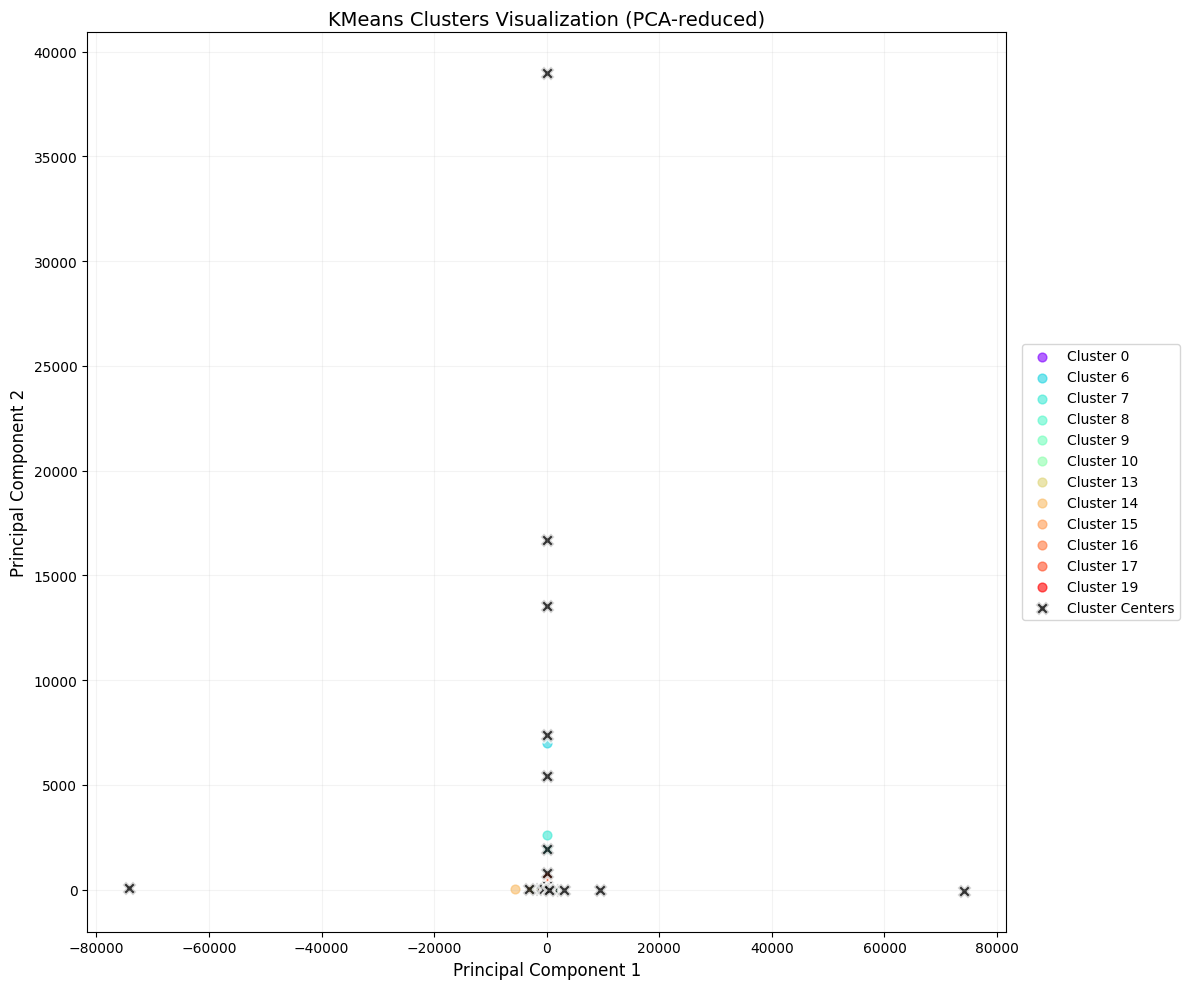

In [18]:
# 12. Plot Clusters (Improved Visibility)
plt.figure(figsize=(12, 10))  # Larger figure

# Create a colormap for the clusters
colors = plt.cm.rainbow(np.linspace(0, 1, 20))

# Plot sample points colored by cluster
for i in range(20):
    cluster_points = [p.pca_features.toArray() for p in points_2d if p.prediction == i]
    if cluster_points:
        cluster_points = np.array(cluster_points)
        plt.scatter(
            cluster_points[:, 0], 
            cluster_points[:, 1], 
            s=40,  # Slightly larger points
            color=colors[i], 
            alpha=0.6,  # More opaque
            label=f"Cluster {i}"
        )

# Plot cluster centers - SMALLER now
centers_2d_array = np.array([c.toArray() for c in centers_2d])
plt.scatter(
    centers_2d_array[:, 0], 
    centers_2d_array[:, 1], 
    s=100,  # Reduced from 200
    marker='X', 
    color='black', 
    alpha=0.8,  # Slightly transparent
    linewidth=2,  # Add outline
    edgecolor='white',  # White outline
    label='Cluster Centers'
)

plt.title("KMeans Clusters Visualization (PCA-reduced)", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)

# Move legend outside plot area completely
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)
plt.tight_layout()
plt.grid(alpha=0.15)  # Light grid
plt.show()